In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression, Lasso #, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append('../data')
    sys.path.append('../src')
from plot_features_importance import plot_features_importance

SEED =9

### Read data

In [2]:
df = pd.read_csv(r"..\data\rental_info.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [3]:
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


### Extract Features


In [4]:
# Create a column named "rental_length_days" using the columns "return_date" and "rental_date", and add it to the pandas DataFrame. 
# This column should contain information on how many days a DVD has been rented by a customer.
date_format = "%Y-%m-%d %H:%M:%S"
df["rental_length_days"] = (pd.to_datetime(df["return_date"], format=date_format) -  pd.to_datetime(df["rental_date"], format=date_format)).dt.days
#df["rental_length_days"]

### Convert special features from object to dummy 

In [5]:
# Create two columns of dummy variables from "special_features", which takes the value of 1 when:
# The value is "Deleted Scenes", storing as a column called "deleted_scenes".
# The value is "Behind the Scenes", storing as a column called "behind_the_scenes". 

df['deleted_scenes'] = np.where(df['special_features'].str.contains("Deleted Scenes"), 1, 0)
df['behind_the_scenes'] = np.where(df['special_features'].str.contains("Behind the Scenes"), 1, 0)
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1


### Separate features and targets

In [8]:
print(list(df.columns))

features_to_keep = [
    #'rental_date', 
    #'return_date', 
    'amount',
    'release_year', 
    'rental_rate',
    'length',
    'replacement_cost', 
    #'special_features', 
    'NC-17', 'PG', 'PG-13', 'R', 'amount_2', 'length_2', 'rental_rate_2', 
    #'rental_length_days', 
    'deleted_scenes', 'behind_the_scenes'
    ]

X = df[features_to_keep]
y = df['rental_length_days']

['rental_date', 'return_date', 'amount', 'release_year', 'rental_rate', 'length', 'replacement_cost', 'special_features', 'NC-17', 'PG', 'PG-13', 'R', 'amount_2', 'length_2', 'rental_rate_2', 'rental_length_days', 'deleted_scenes', 'behind_the_scenes']


### Split data into training and testing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### Tune a lasso regressor 

In [12]:
# Build the steps
steps = [("scaler", StandardScaler()),
         ("lasso", Lasso())]

pipeline = Pipeline(steps)

kf = KFold()

# Create the parameter space
parameters = {"lasso__alpha": np.linspace(0.00001, 1, 20)}

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters, cv=kf, scoring='neg_mean_squared_error')

# Fit to the training data
cv.fit(X_train, y_train)
print(cv.best_score_, "\n", cv.best_params_)

# Fit to the training data
print("Tuned lasso paramaters: {}".format(cv.best_params_))
print("Training lasso score: {:.2f}".format(-cv.best_score_))

# Calculate and print R-squared
print("Testing lasso score: {:.2f}".format(-cv.score(X_test, y_test)))

-2.849075529175262 
 {'lasso__alpha': 1e-05}
Tuned lasso paramaters: {'lasso__alpha': 1e-05}
Training lasso score: 2.85
Testing lasso score: 2.94


### Train various regressors

In [13]:
# Instantiate lr
lr = LinearRegression()

# Instantiate knn
knn = KNeighborsRegressor()

# Instantiate dt
dtr = DecisionTreeRegressor(random_state=SEED)

# Instanciate RF
rf = RandomForestRegressor(random_state=SEED)

# Define the list classifiers
classifiers = [('Logistic Regression', lr), 
               ('K Nearest Neighbours', knn), 
               ('Decision Tree Regressor', dtr),
               ('Random Forest', rf)]

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:    
 
    # Fit clf to the training set
    clf.fit(X_train, y_train)   
   
    # Predict y_pred
    y_pred = clf.predict(X_test)
    
    # Calculate MSE
    mse = MSE(y_test, y_pred) 
   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, mse))

Logistic Regression : 2.942
K Nearest Neighbours : 2.694
Decision Tree Regressor : 2.168
Random Forest : 2.030


### Voting regressors

In [14]:
# Instantiate a VotingClassifier vc
vr = VotingRegressor(estimators=classifiers)    

# Fit vc to the training set
vr.fit(X_train, y_train)  

# Evaluate the test set predictions
y_pred = vr.predict(X_test)

# Calculate MSE
mse = MSE(y_test, y_pred) 
print('Voting Regressor: {:.3f}'.format(mse)) 


Voting Regressor: 2.069


### AdaBoost

In [15]:
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=4, random_state=SEED)

# Instantiate ada
ada = AdaBoostRegressor(estimator=dt, n_estimators=180, random_state=SEED)

# Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
y_pred = ada.predict(X_test)

# MSE
ada_mse = MSE(y_test, y_pred) 

# Print MSE
print('MSE: {:.2f}'.format(ada_mse))


MSE: 2.55


### Bagging

In [16]:
# Instantiate dt
dt = DecisionTreeRegressor(random_state=SEED)

# Instantiate bc
bc = BaggingRegressor(estimator=dt, n_estimators=50, random_state=SEED)

# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate MSE
mse = MSE(y_test, y_pred) 
print('MSE: {:.2f}'.format(ada_mse))


MSE: 2.55


### Tune the hyperparameters of a RF

In [17]:
# Instanciate RF
rf = RandomForestRegressor(random_state=SEED)
#print(dt.get_params())

params_rf = {
    "max_depth": [3, 4, 5, 6],
    "min_samples_leaf": [0.04, 0.06, 0.08],
    "max_features": [0.2, 0.4, 0.6, 0.8]
}

grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=10,
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)

best_hyperparams = grid_rf.best_params_
print("Best hyperparameters:\n", best_hyperparams)

best_CV_score = grid_rf.best_score_
print("Best CV MSE {:.3f}".format(-best_CV_score))

# Extracting the best model
best_model = grid_rf.best_estimator_
best_mse = best_model.score(X_test, y_test)

print("Test set MSE of best model: {:.3f}".format(best_mse))


Best hyperparameters:
 {'max_depth': 5, 'max_features': 0.8, 'min_samples_leaf': 0.04}
Best CV MSE 2.523
Test set MSE of best model: 0.633


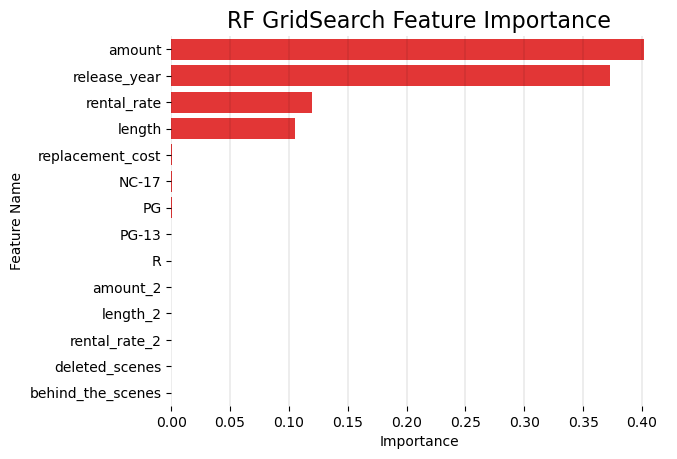

In [18]:
plot_features_importance(best_model.feature_importances_, X_train.columns.to_list(), "RF GridSearch Feature Importance")
